# Two task network 

Network has eight inputs:

1. The fixation. 
1. $u_{rule}^{1}$
1. $u_{rule}^{2}$
1. The first context mod. 
1. The second ontext mod. 
1. The first context status. 
1. The second context status. 
1. The Romo signals.

Network has five outputs: 
1. The fixation. 
1. The first context output. 
1. The second context output. 
1. The first Romo task output. 
1. The second Romo task output. 


<div>
<img src="./images/Sheme.png" width="300"/>
</div>

> Learning rule: superspike

> Neuron type: Alif

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt  # for analys
from cgtasknet.net.lifadex import SNNlifadex
from cgtasknet.tasks.tasks import MultyTask
from norse.torch.functional.lif_adex import LIFAdExParameters

## Step -1: Create dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')

Device: gpu (cuda)


In [3]:
batch_size = 100
number_of_tasks = 1
task_list = [("WorkingMemory", dict()), (("ContextDM", dict()))]
tasks = dict(task_list)
Task = MultyTask(tasks=tasks, batch_size=batch_size)

## Step 1.1: Create model

In [4]:
feature_size, output_size = Task.feature_and_act_size[0]
hidden_size = 400

neuron_parameters = LIFAdExParameters(
    tau_ada_inv=torch.Tensor([2]).to(device), alpha=100
)
model = SNNlifadex(
    feature_size, hidden_size, output_size, neuron_parameters=neuron_parameters
).to(device)

## Step 1.2: Save pre-learning weights

In [5]:
weights_pre_l = []
with torch.no_grad():
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_pre_l.append((param).cpu().numpy())

## Step 2: loss and creterion 

In [19]:
learning_rate = 5e-3


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


criterion = RMSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.8, 0.85))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.8, 0.85))

## Step 3: Train loop

In [20]:
%matplotlib
plt.ion
fig = plt.figure()
ax = fig.add_subplot(111)
fig2 = plt.figure()

ax2 = fig2.add_subplot(111)
ax2.set_title("lifadex")
ax.set_title("lifadex")
inputs, target_outputs = Task.dataset(number_of_tasks)
(line1,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line2,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
(line3,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line4,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
(line21,) = ax2.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line22,) = ax2.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
(line23,) = ax2.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line24,) = ax2.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([0, len(inputs) * 2])
ax2.set_ylim([-0.5, 1.5])
ax2.set_xlim([0, len(inputs) * 2])
running_loss = 0
fig.canvas.draw()
fig.canvas.flush_events()
fig2.canvas.draw()
fig2.canvas.flush_events()
for i in range(2000):
    inputs, target_outputs = Task.dataset(number_of_tasks)
    inputs += np.random.normal(0, 0.01, size=(inputs.shape))
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, states = model(inputs)

    loss = criterion(outputs, target_outputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 10 == 9:
        print("epoch: {:d} loss: {:0.5f}".format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            inputs, target_outputs = Task.dataset(number_of_tasks)

            inputs = torch.from_numpy(inputs).type(torch.float).to(device)
            target_outputs = (
                torch.from_numpy(target_outputs).type(torch.float).to(device)
            )
            outputs, states = model(inputs)
            loss = criterion(outputs, target_outputs)

            print("test loss: {:0.5f}".format(loss.item()))
        for_plot = outputs.detach().cpu().numpy()[:, 0, :]
        line1.set_xdata(np.arange(0, len(for_plot), 1))
        line2.set_xdata(np.arange(0, len(for_plot), 1))
        line3.set_xdata(np.arange(0, len(for_plot), 1))
        line4.set_xdata(np.arange(0, len(for_plot), 1))
        line21.set_xdata(np.arange(0, len(for_plot), 1))
        line22.set_xdata(np.arange(0, len(for_plot), 1))
        line23.set_xdata(np.arange(0, len(for_plot), 1))
        line24.set_xdata(np.arange(0, len(for_plot), 1))

        line1.set_ydata(for_plot[:, 1])
        line2.set_ydata(for_plot[:, 2])
        line3.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 1])
        line4.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 2])

        line21.set_ydata(for_plot[:, 3])
        line22.set_ydata(for_plot[:, 4])
        line23.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 3])
        line24.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 4])

    fig.canvas.draw()
    fig.canvas.flush_events()
    fig2.canvas.draw()
    fig2.canvas.flush_events()


print("Finished Training")

Using matplotlib backend: TkAgg
epoch: 10 loss: 0.18449
test loss: 0.09254
epoch: 20 loss: 0.15161
test loss: 0.22539
epoch: 30 loss: 0.17769
test loss: 0.25145
epoch: 40 loss: 0.11678
test loss: 0.07735
epoch: 50 loss: 0.11067
test loss: 0.08691
epoch: 60 loss: 0.15059
test loss: 0.08873
epoch: 70 loss: 0.17330
test loss: 0.24495
epoch: 80 loss: 0.14698
test loss: 0.24791
epoch: 90 loss: 0.14915
test loss: 0.25060
epoch: 100 loss: 0.14311
test loss: 0.08498
epoch: 110 loss: 0.19034
test loss: 0.23371
epoch: 120 loss: 0.18022
test loss: 0.09604
epoch: 130 loss: 0.14925
test loss: 0.22480
epoch: 140 loss: 0.14106
test loss: 0.22239
epoch: 150 loss: 0.22483
test loss: 0.23953
epoch: 160 loss: 0.14794
test loss: 0.23521
epoch: 170 loss: 0.17186
test loss: 0.10210
epoch: 180 loss: 0.18638
test loss: 0.09301
epoch: 190 loss: 0.14704
test loss: 0.10533
epoch: 200 loss: 0.14797
test loss: 0.24031
epoch: 210 loss: 0.16625
test loss: 0.10256
epoch: 220 loss: 0.16274
test loss: 0.11839
epoch: 23

In [9]:
# torch.save(model.state_dict(), "lif_adex_romo_and_ctx_1510_iterations_steps_lr_1e-3")

In [5]:
if False:
    model.load_state_dict(
        torch.load("lif_adex_romo_and_ctx_1510_iterations_steps_lr_1e-3")
    )

<All keys matched successfully>

In [9]:
Taskplot = MultyTask(tasks=tasks, batch_size=1)
inputs, target_outputs = Taskplot.dataset(10)
inputs += np.random.normal(0, 0.01, size=(inputs.shape))
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
outputs, states = model(inputs)

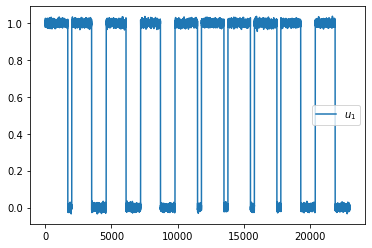

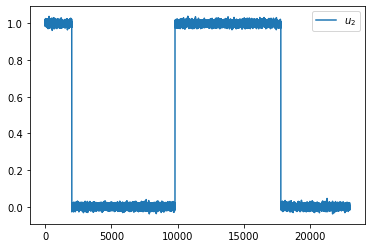

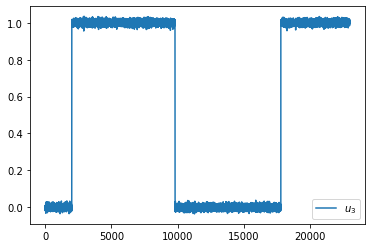

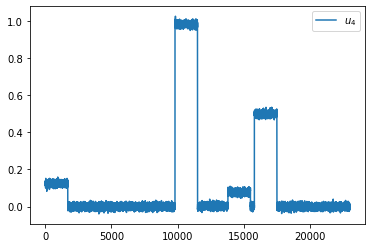

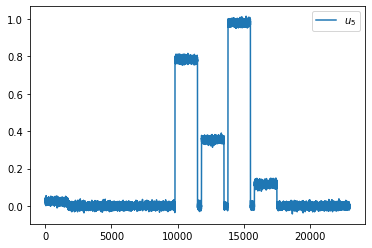

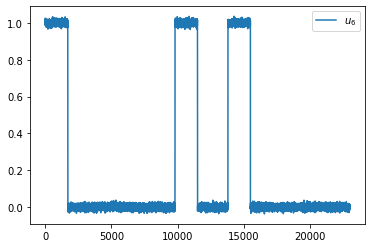

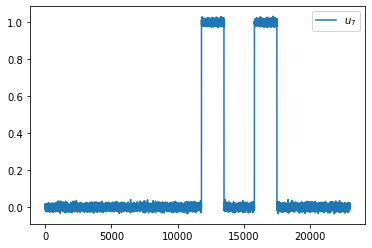

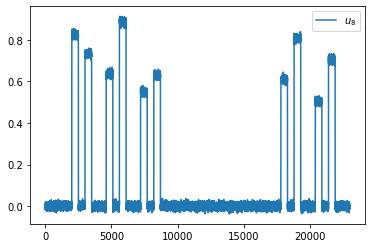

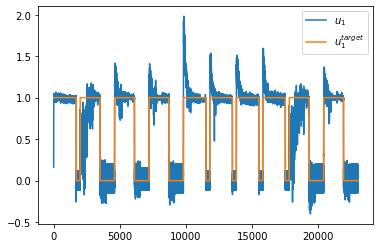

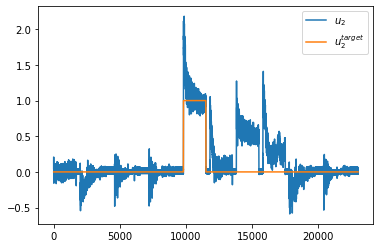

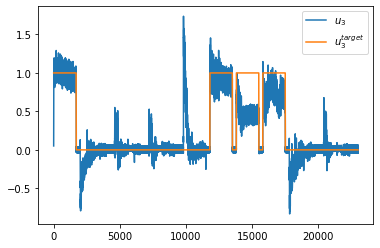

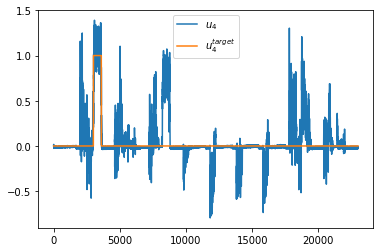

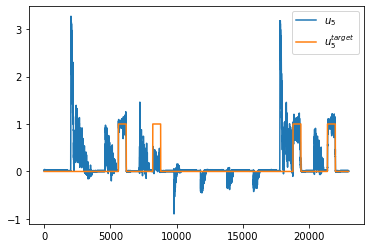

In [14]:
%matplotlib inline
for i in range(inputs.shape[2]):
    plt.plot(inputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")
    plt.legend()
    plt.show()
    plt.close()
for i in range(outputs.shape[2]):
    plt.plot(outputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")
    plt.plot(
        target_outputs[:, 0, i].detach().cpu().numpy(), label=fr"$u^{{target}}_{i + 1}$"
    )
    plt.legend()
    plt.show()
    plt.close()